In [1]:
import os
import glob
import numpy as np
import cv2


def data_loader(filepath: str) -> tuple[np.ndarray, np.ndarray]:
    data_list = []
    label_list = []
    class_folder_list = ['Carambula', 'Lychee', 'Pear']
    for i, class_folder in enumerate(class_folder_list):
        class_folder_path = os.path.join(filepath, class_folder)
        img_files = [f for f in os.listdir(class_folder_path) if f.endswith('.png')]
        data = np.zeros((len(img_files), 32 * 32), dtype=int)
        label = np.zeros((len(img_files),), dtype=int)
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(class_folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            data[j] = np.array(img).flatten()
            label[j] = i
        data_list.append(data)
        label_list.append(label)

    data_array = np.concatenate(data_list)
    label_array = np.concatenate(label_list)
    return data_array, label_array

train_data_array, train_label_array = data_loader('D:\Data_train')
test_data_array, test_label_array = data_loader('D:\Data_test')


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data_array)

train_data_array = scaler.transform(train_data_array)
test_data_array = scaler.transform(test_data_array)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pca.fit(train_data_array)

train_features = pca.transform(train_data_array)
test_features = pca.transform(test_data_array)

X_train, y_train = train_features, train_label_array
X_test, y_test = test_features, test_label_array

In [4]:
import numpy as np


class MYNN:
    def __init__(
        self,
        hidden_layer_sizes: tuple = (150,),
        use_bias: bool = True,
        batch_size: int = 128,
        epoch: int = 150,
        learning_rate: float = 1e-3,
        random_seed: int = None,
        verbose: bool = False
    ) -> None:
        if isinstance(hidden_layer_sizes, int):
            self.hidden_layer_sizes = [hidden_layer_sizes]
        elif isinstance(hidden_layer_sizes, tuple):
            self.hidden_layer_sizes = list(hidden_layer_sizes)
        else:
            self.hidden_layer_sizes = hidden_layer_sizes
        self.use_bias = use_bias
        self.batch_size = batch_size
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        self.verbose = verbose
        self.CONST = 1e-9

    def _initialize(self, layer_units: list) -> None:
        self.n_layer = len(layer_units) - 1
        self.params = {}
        self.batch_params = {}
        self.loss_curve = []

        for i in range(1, self.n_layer + 1):
            self.params[f'weight{i}'] = np.random.rand(layer_units[i - 1], layer_units[i])
            if self.use_bias:
                self.params[f'bias{i}'] = np.random.rand(1, layer_units[i])

        for i in range(1, self.n_layer):
            self.batch_params[f'mean{i}'] = np.zeros((layer_units[i],))
            self.batch_params[f'std{i}'] = np.zeros((layer_units[i],))

    def _batch_norm(self, X: np.ndarray, layer_idx: int, trainable: bool = False) -> np.ndarray:
        if trainable:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            if f'mean{layer_idx}' not in self.batch_params:
                self.batch_params[f'mean{layer_idx}'] = mean
                self.batch_params[f'std{layer_idx}'] = std

            self.batch_params[f'mean{layer_idx}'] = self.batch_params[f'mean{layer_idx}'] * 0.8 + mean * 0.2
            self.batch_params[f'std{layer_idx}'] = self.batch_params[f'std{layer_idx}'] * 0.8 + std * 0.2
        else:
            mean = self.batch_params[f'mean{layer_idx}']
            std = self.batch_params[f'std{layer_idx}']
        return (X - mean) / (std + self.CONST)

    def _batch_norm_derivative(self, X: np.ndarray) -> np.ndarray:
        return 1.0 / (np.std(X, axis=0) + self.CONST)

    def _sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-X))

    def _sigmoid_derivative(self, X: np.ndarray) -> np.ndarray:
        return self._sigmoid(X) * (1.0 - self._sigmoid(X))

    def _softmax(self, X: np.ndarray) -> np.ndarray:
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)

    def _cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return np.sum(-y_true * np.log(y_pred + self.CONST), axis=1)

    def _softmax_and_cross_entropy_derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return y_pred - y_true

    def _accuracy_score(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        if y_true.ndim == 2:
            y_true = np.argmax(y_true, axis=1)
        if y_pred.ndim == 2:
            y_pred = np.argmax(y_pred, axis=1)
        return float(np.sum([y_true == y_pred]) / y_true.shape[0])

    def _forward_pass(self, X: np.ndarray, trainable: bool = False) -> tuple[np.ndarray, dict, dict]:
        z, a = {}, {}
        L = self.n_layer

        a[0] = X
        for k in range(1, L):
            z[k] = a[k - 1] @ self.params[f'weight{k}'] + (self.params[f'bias{k}'] if self.use_bias else 0)
            norm = self._batch_norm(z[k], k, trainable=trainable)
            a[k] = self._sigmoid(norm)
        z[L] = a[L - 1] @ self.params[f'weight{L}'] + (self.params[f'bias{L}'] if self.use_bias else 0)
        out = self._softmax(z[L])
        return out, z, a

    def _backprop(self, X: np.ndarray, y: np.ndarray) -> tuple[float, float]:
        out, z, a = self._forward_pass(X, trainable=True)

        delta = {}
        L = self.n_layer

        delta[L] = self._softmax_and_cross_entropy_derivative(y, out)
        for k in range(L - 1, 0, -1):
            delta[k] = delta[k + 1] @ self.params[f'weight{k + 1}'].T * \
                self._sigmoid_derivative(z[k]) * self._batch_norm_derivative(z[k])

        for k in range(1, L + 1):
            gradient = a[k - 1].T @ delta[k]
            self.params[f'weight{k}'] -= self.learning_rate * gradient
            if self.use_bias:
                gradient = np.ones((a[k - 1].shape[0], 1)).T @ delta[k]
                self.params[f'bias{k}'] -= self.learning_rate * gradient

        loss = np.mean(self._cross_entropy(y, out))
        accuracy = self._accuracy_score(y, out)
        return loss, accuracy

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        np.random.seed(self.random_seed)
        self.output_dim = y.ndim
        if self.output_dim == 1:
            y = np.eye(len(np.unique(y)), dtype=int)[y]

        n_samples, n_features = X.shape
        self.n_outputs = y.shape[1]
        layer_units = [n_features] + self.hidden_layer_sizes + [self.n_outputs]
        self._initialize(layer_units)

        indices = np.arange(n_samples)
        max_iter = n_samples // self.batch_size
        for i in range(self.epoch):
            np.random.shuffle(indices)
            accumulated_loss = 0
            accumulated_accuracy = 0
            for j in range(max_iter):
                idx = indices[j * self.batch_size:(j + 1) * self.batch_size]
                batch_loss, batch_accuracy = self._backprop(X[idx], y[idx])
                accumulated_loss += batch_loss
                accumulated_accuracy += batch_accuracy

            loss = accumulated_loss / max_iter
            accuracy = accumulated_accuracy / max_iter
            if self.verbose:
                print(f'Epoch {i:d}, training loss = {loss:f}, accuracy = {accuracy:f}')
            self.loss_curve.append(loss)

    def predict(self, X: np.ndarray) -> np.ndarray:
        y_pred_prob, _, _ = self._forward_pass(X)
        y_pred = np.argmax(y_pred_prob, axis=1)
        if self.output_dim == 2:
            y_pred = np.eye(self.n_outputs, dtype=int)[y_pred]
        return y_pred

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        y_pred_prob, _, _ = self._forward_pass(X)
        return y_pred_prob





In [5]:
from sklearn.metrics import accuracy_score

nn2 = MYNN(random_seed=0)
nn2.fit(X_train, y_train)

print('Accuracy of 2NN:')
y_pred = nn2.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = nn2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of 2NN:
Training accuracy: 0.834014
Testing accuracy: 0.921687


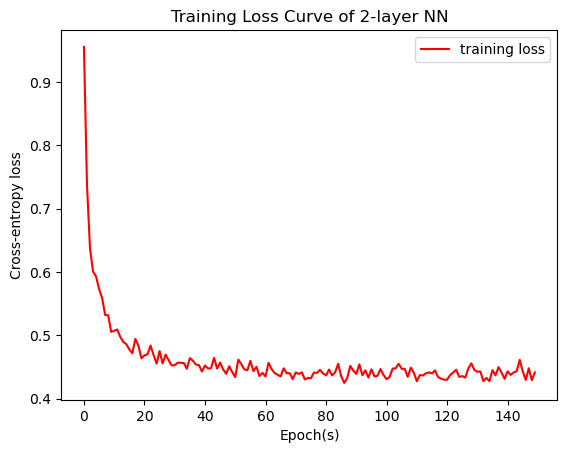

In [9]:
import matplotlib.pyplot as plt


def plot_training_loss_curve(clf: MYNN) -> None:
    plt.plot(clf.loss_curve, 'r-', label='training loss')
    plt.title(f'Training Loss Curve of {clf.n_layer}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()


plot_training_loss_curve(nn2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


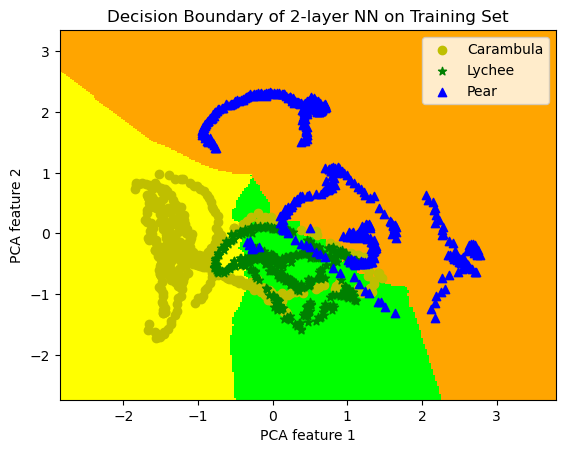

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


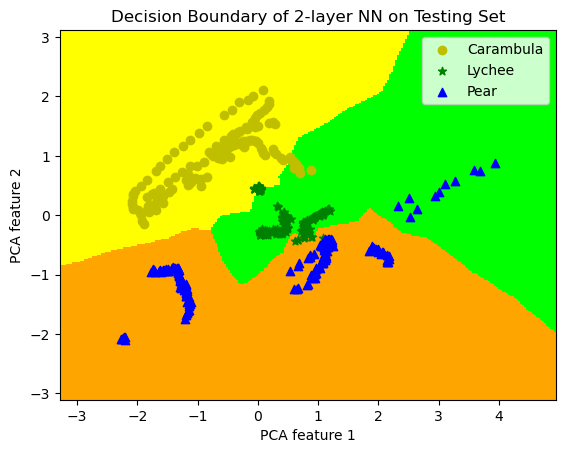

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_boundary(clf: MYNN, X: np.ndarray, y: np.ndarray, title: str) -> None:
    y_pred = clf.predict(X)
    y_true = y

    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    pca = PCA(n_components=2, random_state=0)
    pca.fit(X)
    X = pca.transform(X)

    knn = KNeighborsClassifier()
    knn.fit(X, y_pred)

    x_min, y_min = np.min(X, axis=0) - 1
    x_max, y_max = np.max(X, axis=0) + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250), np.linspace(y_min, y_max, 250))
    color_label = knn.predict(np.c_[xx.flatten(), yy.flatten()]).reshape(xx.shape)

    labels = [0, 1, 2]
    colors = ['y', 'g', 'b']
    markers = ['o', '*', '^']
    names = ['Carambula', 'Lychee', 'Pear']
    cmap = ListedColormap(['#FFFF00', '#00FF00', '#FFA500'])

    plt.figure()
    plt.pcolormesh(xx, yy, color_label, cmap=cmap)
    for label, color, marker, name in zip(labels, colors, markers, names):
        plt.scatter(X[label == y_true, 0], X[label == y_true, 1], c=color, marker=marker, label=name)
    plt.title(f'Decision Boundary of {clf.n_layer}-layer NN on {title} Set')
    plt.xlabel('PCA feature 1')
    plt.ylabel('PCA feature 2')
    plt.legend(loc='upper right')
    plt.show()


plot_decision_boundary(nn2, X_train, y_train, 'Training')
plot_decision_boundary(nn2, X_test, y_test, 'Testing')

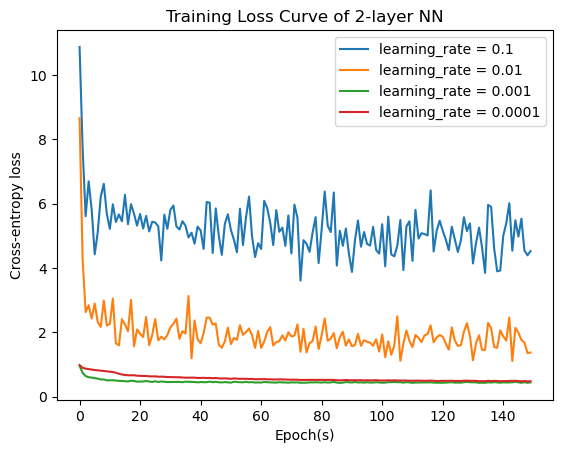

In [15]:
import matplotlib.pyplot as plt


def plot_learning_rate_comparison(X: np.ndarray, y: np.ndarray, hidden_layer_sizes: tuple) -> None:
    for i in range(1, 5):
        learning_rate = 10 ** (-i)
        nn = MYNN(random_seed=0, hidden_layer_sizes=hidden_layer_sizes, learning_rate=learning_rate)
        nn.fit(X, y)
        plt.plot(nn.loss_curve, label=f'learning_rate = {learning_rate}')
    plt.title(f'Training Loss Curve of {nn.n_layer}-layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()


plot_learning_rate_comparison(X_train, y_train, (150,))

In [22]:
from sklearn.metrics import accuracy_score

nn3 = MYNN(random_seed=0, hidden_layer_sizes=(150, 100))
nn3.fit(X_train, y_train)

print('Accuracy of 3NN:')
y_pred = nn3.predict(X_train)
print(f'Training accuracy: {accuracy_score(y_train, y_pred):f}')

y_pred = nn3.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy of 3NN:
Training accuracy: 0.812245
Testing accuracy: 0.845382


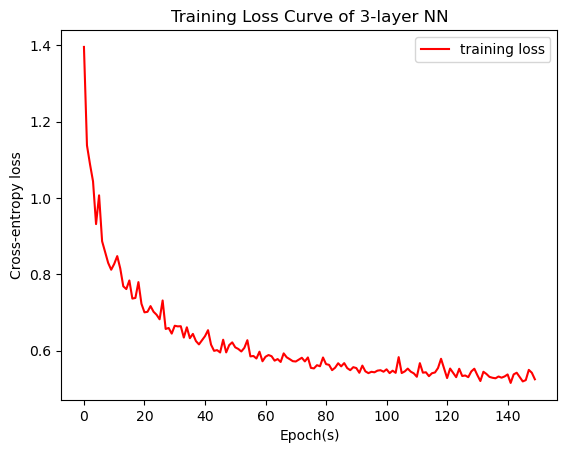

In [18]:
plot_training_loss_curve(nn3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


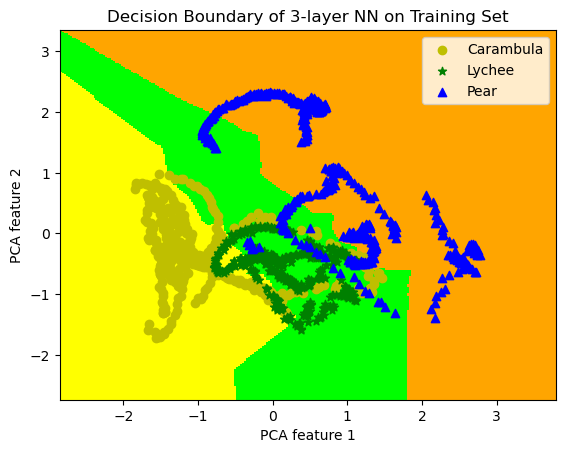

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


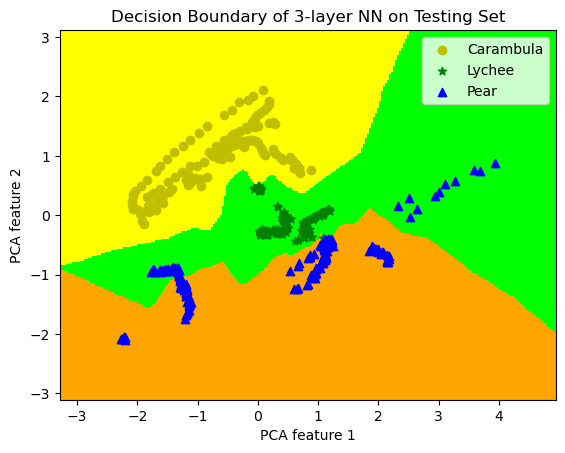

In [19]:
plot_decision_boundary(nn3, X_train, y_train, 'Training')
plot_decision_boundary(nn3, X_test, y_test, 'Testing')

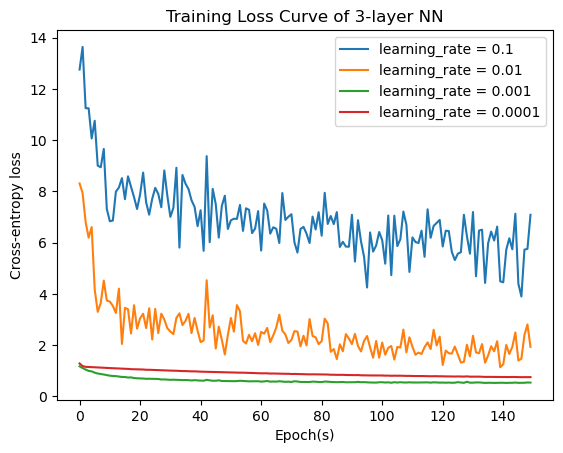

In [21]:
plot_learning_rate_comparison(X_train, y_train, (150, 100))